#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df = df.sort_index()
df = df.resample('1H').sum()

Выполним ресемплирование данных по одному часу

In [6]:
df.index.is_monotonic

True

Проверим, что даты идут по порядку

## Анализ

Разложим данные на три составляющие: тренд, сезонность и остаток.

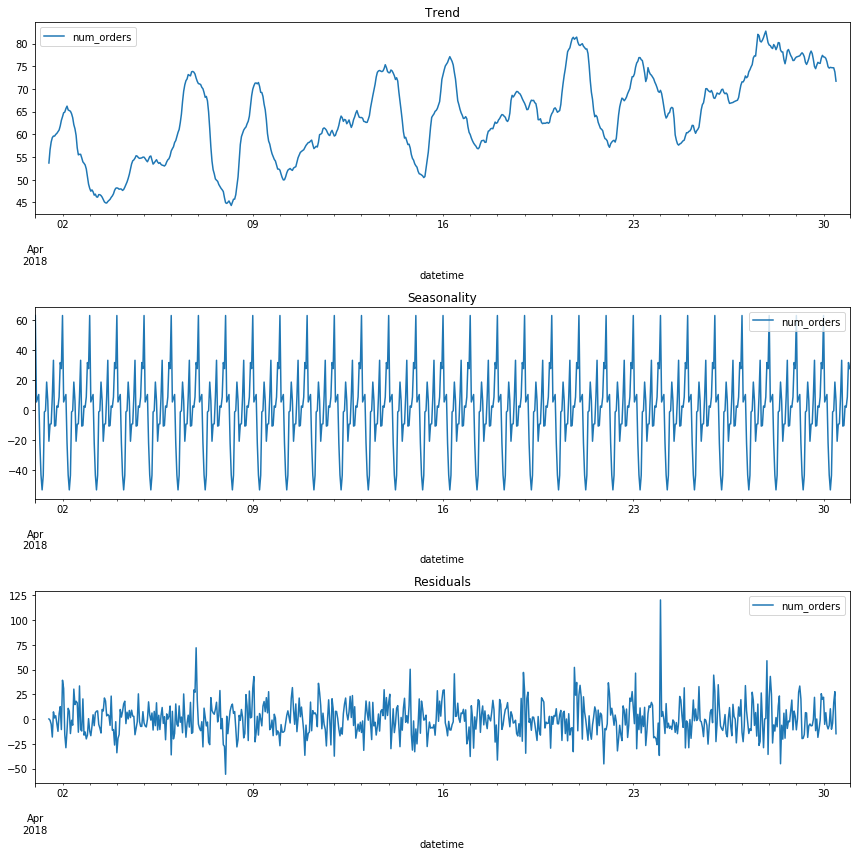

In [7]:
decomposed = seasonal_decompose(df['2018-04':'2018-04'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

-Распределение сезонной части выглядит статическим в интервале суток

-Тренд показывает линейный рост количества заказов со временем

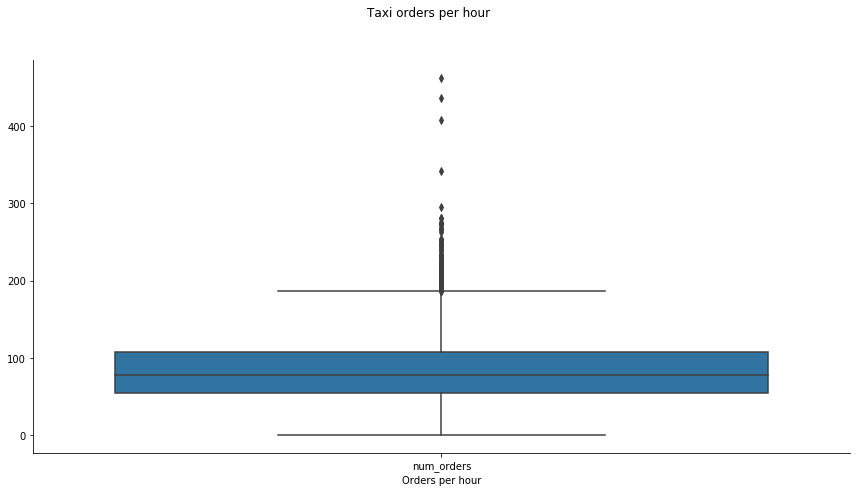

In [8]:
plot = sns.catplot(data=df, kind='box', height=6, aspect=2, legend_out=False)
plot.set_axis_labels(x_var='Orders per hour')
plot.set
plot.fig.suptitle('Taxi orders per hour', y=1.1);

В среднем в час заказов в такси бывает около 100, но бывают и такое, что в час заказывают 200 и больше.

Text(0.5, 1.0, 'Trend')

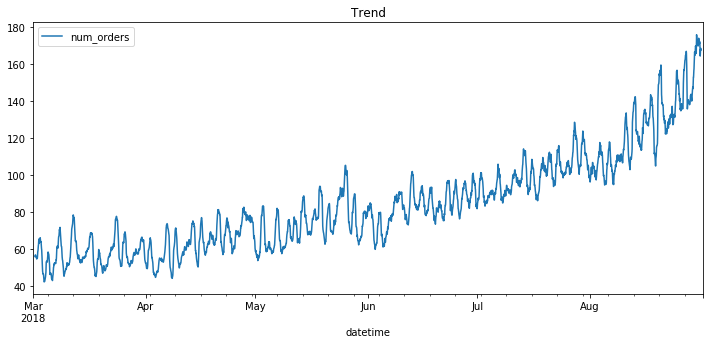

In [9]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

За весь период тренд показывает линейный рост количества заказов, возможно это связано с тем, что компания только набирает оборот, и постепенно кол-во заказов становится больше.

## Обучение

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE baseline модели:", round(rmse_base, 3))

RMSE baseline модели: 53.368


В качестве baseline модели будем предсказывать новые значения предыдущими

In [11]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE baseline модели:", mean_squared_error(test['num_orders'], pred_mean) ** 0.5)

RMSE baseline модели: 74.42015786913375


А также будем предсказывать средним значением.

Напишем функцию для создания обучающих признаков

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [13]:
df_new = make_features(df, 10, 10)

In [14]:
df_new.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

### ***Линейная регрессия***

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
print("RMSE на обучающей выборке:", mean_squared_error(y_train, preds_train) ** 0.5)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, preds_test) ** 0.5)

RMSE на обучающей выборке: 31.26856904327208
RMSE на тестовой выборке:  54.60984980574331


In [18]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

Подберем оптимальные параметры, чтобы улучшить качество модели.

In [19]:
%%time
best_lag = 0
best_roll_size = 0
best_rmse = 74
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):

        new_df = make_features(df, lag, roll_size)
        train, test = train_test_split(new_df, shuffle=False, test_size=0.2)
        train = train.dropna()
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']
        X_test = test.drop('num_orders', axis = 1)
        y_test = test['num_orders']

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        mse = cross_val_score(lr, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error') 
        rmse = (-mse.mean()) ** 0.5
        if rmse < best_rmse :
            best_rmse = rmse
            best_lag = lag
            best_roll_size = roll_size
print('RMSE на тестовой выборке:', best_rmse)
print('максимальное смещение:',best_lag)
print('размер скользящего окна:',best_roll_size)

RMSE на тестовой выборке: 23.5642736943987
максимальное смещение: 96
размер скользящего окна: 91
CPU times: user 2min 43s, sys: 2min 44s, total: 5min 28s
Wall time: 5min 28s


### ***Lasso***

In [20]:
%%time
best_lag_ls = 0
best_roll_size_ls = 0
best_alpha_ls = 0
best_rmse_ls = 74
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):
        for alpha in np.arange(0.1, 1, 0.2):

            new_df_1 = make_features(df, lag, roll_size)
            train, test = train_test_split(new_df_1, shuffle=False, test_size=0.2)
            train = train.dropna()
            X_train = train.drop('num_orders', axis = 1)
            y_train = train['num_orders']
            X_test = test.drop('num_orders', axis = 1)
            y_test = test['num_orders']
                
            ls = Lasso(alpha=alpha)
            ls.fit(X_train, y_train)

            mse = cross_val_score(ls, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error') 
            rmse = (-mse.mean()) ** 0.5
            if rmse < best_rmse_ls :
                best_rmse_ls = rmse
                best_lag_ls = lag
                best_roll_size_ls = roll_size
                best_alpha_ls = alpha
print('RMSE на тестовой выборке:',best_rmse_ls)
print('максимальное смещение:',best_lag_ls)
print('размер скользящего окна:',best_roll_size_ls)
print('Коэффициент регуляризации:',best_alpha_ls)

RMSE на тестовой выборке: 23.470967705055045
максимальное смещение: 96
размер скользящего окна: 1
Коэффициент регуляризации: 0.9000000000000001
CPU times: user 20min 10s, sys: 19min 50s, total: 40min 1s
Wall time: 40min 2s


### ***Ridge***

In [21]:
%%time
best_lag_rd = 0
best_roll_size_rd = 0
best_alpha_rd = 0
best_rmse_rd = 74
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):
        for alpha in np.arange(0.1, 1, 0.2):

            new_df_2 = make_features(df, lag, roll_size)
            train, test = train_test_split(new_df_2, shuffle=False, test_size=0.2)
            train = train.dropna()
            X_train = train.drop('num_orders', axis = 1)
            y_train = train['num_orders']
            X_test = test.drop('num_orders', axis = 1)
            y_test = test['num_orders']
                
            rd = Ridge(alpha=alpha)
            rd.fit(X_train, y_train)

            mse = cross_val_score(rd, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error') 
            rmse = (-mse.mean()) ** 0.5
            if rmse < best_rmse_rd :
                best_rmse_rd = rmse
                best_lag_rd = lag
                best_roll_size_rd = roll_size
                best_alpha_rd= alpha
print('RMSE на тестовой выборке:',best_rmse_rd)
print('максимальное смещение:',best_lag_rd)
print('размер скользящего окна:',best_roll_size_rd)
print('Коэффициент регуляризации:',best_alpha_rd)

RMSE на тестовой выборке: 23.576746508510634
максимальное смещение: 96
размер скользящего окна: 6
Коэффициент регуляризации: 0.9000000000000001
CPU times: user 10min 28s, sys: 11min 15s, total: 21min 43s
Wall time: 21min 44s


In [22]:
res = pd.DataFrame([['Baseline', round(rmse_base, 2), 1, 0, np.nan],
                      ['Linear Regression', round(best_rmse, 2), best_lag, best_roll_size, np.nan],
                      ['Lasso', round(best_rmse_ls, 2), best_lag_ls, best_roll_size_ls, best_alpha_ls],
                      ['Ridge', round(best_rmse_rd, 2), best_lag_rd, best_roll_size_rd, best_alpha_rd]],
                    columns = ['model', 'rmse', 'max_lag', 'roll_size', 'alpha'])

In [23]:
res

,model,rmse,max_lag,roll_size,alpha
0,Baseline,53.37,1,0,NaN
1,Linear Regression,23.56,96,91,NaN
2,Lasso,23.47,96,1,0.9
3,Ridge,23.58,96,6,0.9


## Выводы

1) Удалось достигнуть уменьшения RMSE по сравнению с baseline моделью.

2) Все модели показывают примерно одинаковый результат RMSE 35.7.

3) Не понятно почему у всех моделей максимальное смещение 1.!!!

4) Наилучший результат даёт скользящее окно размером ~40-50 часов (около двух дней)